In [1]:
import jax
import equinox as eqx
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import vmap
from matplotlib import colormaps

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files


def load_cal(file_path, dithers=5):
    files = get_files(
        [f"{file_path}/CAL04481/calslope/"],
        "calslope",
        IS_PSF=[True],  # Calibrators
        EXPOSURE=[str(i + 1) for i in range(dithers)],
        FILTER=["F380M", "F430M", "F480M"],
    )
    for file in files:
        file["BADPIX"].data[:, -1:] = 1
        file["BADPIX"].data[41:43, 1] = 1
        file["BADPIX"].data[58, 67] = 1
    return files

In [3]:
from amigo.model_fits import PointFit
from amigo.misc import populate_from_state
from amigo.core_models import initialise_model
from amigo.ramp_models import build_pooled_layers, MinimalConv

# Load the state
# idx = 48
# idx = 84
idx = 125
path = "/Users/louis/PhD/Software/sandbox/amigo_notebooks/bunya/results/calibrate"
config = np.load(f"{path}/configs/config_{idx}.npy", allow_pickle=True).item()
calib_state = np.load(f"{path}/calib/final_states/state_{idx}.npy", allow_pickle=True).item()

# Build the model
files = load_cal("data/JWST", dithers=1)
model, exposures = initialise_model(files, PointFit(), Teff_cache="../data/Teffs")
ramp = MinimalConv(*build_pooled_layers(config["width"], config["depth"]))
model = model.set("ramp", ramp)
model = populate_from_state(model, calib_state)

/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.

In [4]:
# from amigo.plotting import summarise_fit

# for exp in exposures:

#     summarise_fit(exp, model)

## A Physics principled charge migration model of detectors

Here we use the 'funnel' mental model of the JWST detectors - Each pixel is a 'funnel' that collects charge from the photosensitive substrate. Each of these funnels has an electric potential that pulls the charge towards the readout node. As charge build up in a funnel its electric potential is reduced, and freshly produced photo-electrons at the top of the substrate fall into the neighbouring funnel due to the the potential gradient (along with a possible diffusion term). Using this model we can construct an ODE based on the physics of the charge distribution.

We define $$\frac{dq}{dt} = I + g(\vec{q}) I + f(\vec{q})$$

Where I is the illuminance, g is the non-linear part of the gain curve, here defined to be purely a function of the existing charge in the pixel, and f in the remaining non-linearity that describes how the charge migrates to different funnels based on the electric potential.

We can then define the remaining non-linear term in the ODE that describes our charge migration via the divergence of the _current density_ (via the divergence theorem, this is the equivalent to the total flux of the current field through the boundary of the pixel).

### Current Density in a substrate

$$ \vec{J} = \sigma \vec{E} - D \nabla q $$

Where $\sigma$ is the conductivity of the material, $\vec{E}$ is the electric field, $D$ is the diffusion coefficient.

We can then define our differential equation as:

$$\frac{dq}{dt} = I + g(\vec{q}) I + \nabla \cdot \vec{J(\vec{q})}$$

$$\frac{dq}{dt} = I + g(\vec{q}) I + \nabla \cdot (\sigma \vec{E} - D \nabla \vec{q})$$

Lets look at the terms one by one:

- $I$: The illuminance, simple enough.
- $g(\vec{q})$: The non-linear gain term, this is a function of the charge in the pixel.
- $\nabla \cdot \vec{J(\vec{q})}$: the divergence of the current density. This term describes how the charge migrates to neighbouring pixels based on the electric potential.
    - $D \nabla \vec{q}$: The diffusion term, this term describes how the charge diffuses to neighbouring pixels, based on the spatial gradients of the charge.
    - $\sigma \vec{E}$: The drift term, this term describes how the charge is pulled towards the readout node based on the electric potential.

### The E-Field

The electric field is related to the electric potential via the gradient:

$$ \vec{E} = -\nabla V $$

We want to find the electric potential $V$, which we can do this using the greens function for 2d potentials:

$$G(x, y) = \frac{\rho}{\sqrt{x^2 + y^2}}$$

From this we can build a simple kernel that obeys this equation and then convolve it with the charge distribution to find the electric potential.

$$V(q) = \vec{G} * \vec{q}$$

Note I've added $\rho$ as a scaling constant, since we do not want to work in physics units here, buts its equivalent is the electric permittivity of the material.

### The Pixel Potential

This is all quite straight forwards, and essentially describes a parametric version what we have been doing already with a NN, where we use a Neural Network to predict $g(\vec{q})$ and $f(\vec{q})$. What makes this approach any different?

Well the key here is that we define our dynamics based on _potentials_, which means we can account for the _potential of the pixel_ - ie we can describe the funnel, either via its electric potential or an equivalent charge distribution!

This means that we now describe our total $E$ field as the sum of the two charge and pixel components: $\vec{E} = \vec{E}_{\text{charge}} + \vec{E}_{\text{pixel}}$. Now since we don't actually know the potential of the pixel this becomes another free parameter in our model, which we can learn from the data:

$$\frac{dq}{dt} = I + g(\vec{q}) + \nabla \cdot (\sigma (\vec{E}_{\text{charge}} + \alpha \vec{E}_{\text{pixel}}) - D \nabla \vec{q})$$

Where $\alpha$ is the free parameter that describes the overall potential scale of the pixel, note we also have the define some function that described the _shape_ of the potential over the pixel (ie a Gaussian).

### Looking at the terms in more detail

The gain term:

$$g(\vec{q}) = \text{Poly}(\vec{c}, \vec{q})$$

We only need some small number of coefficients here to describe the non-linearity of the gain curve.

The Electric Fields:

$$\vec{E}_{\text{charge}} = -\nabla V_{\text{charge}} = -\nabla (\vec{G}(\rho) * \vec{q})$$

One parameter, $\rho$, that describes the electric permittivity of the material.

$$\vec{E}_{\text{pixel}} = -\nabla V_{\text{pixel}} = ?$$

We can choose any form for $V_{\text{pixel}}$, we can start with something dumb and parametric like a powered Gaussian.

---

### Model summary

Using this parametric model we only have a few physically principled parameters to learn.

Parameters:
- $\vec{c}$: The coefficients of the gain curve.
- $\rho$: The electric permittivity of the material.
- $\alpha$: The overall potential scale of the pixel.
- $\sigma$: The conductivity of the material.
- $D$: The diffusion coefficient.
- $\vec{G}$: The kernel that describes the electric potential of the charge distribution.


In [5]:
def tile_pixels(pixel_potential, npix):
    oversample = pixel_potential.shape[0]
    empty = np.ones((npix, npix))
    bc_sens_map = pixel_potential[None, :, None, :] * empty[:, None, :, None]
    return bc_sens_map.reshape((npix * oversample, npix * oversample))

def charge_to_potential(charge, zeta, epsilon=1e-9):
    coords = dlu.pixel_coords(9, 2)
    greens_function = zeta / np.hypot(*(coords + epslion))
    return jsp.signal.convolve(charge, greens_function, mode="same")

def potential_to_field(potential):
    return np.array(np.gradient(potential))

def field_to_divergence(field):
    return np.array(np.gradient(field[0], axis=0)) + np.array(np.gradient(field[1], axis=1))


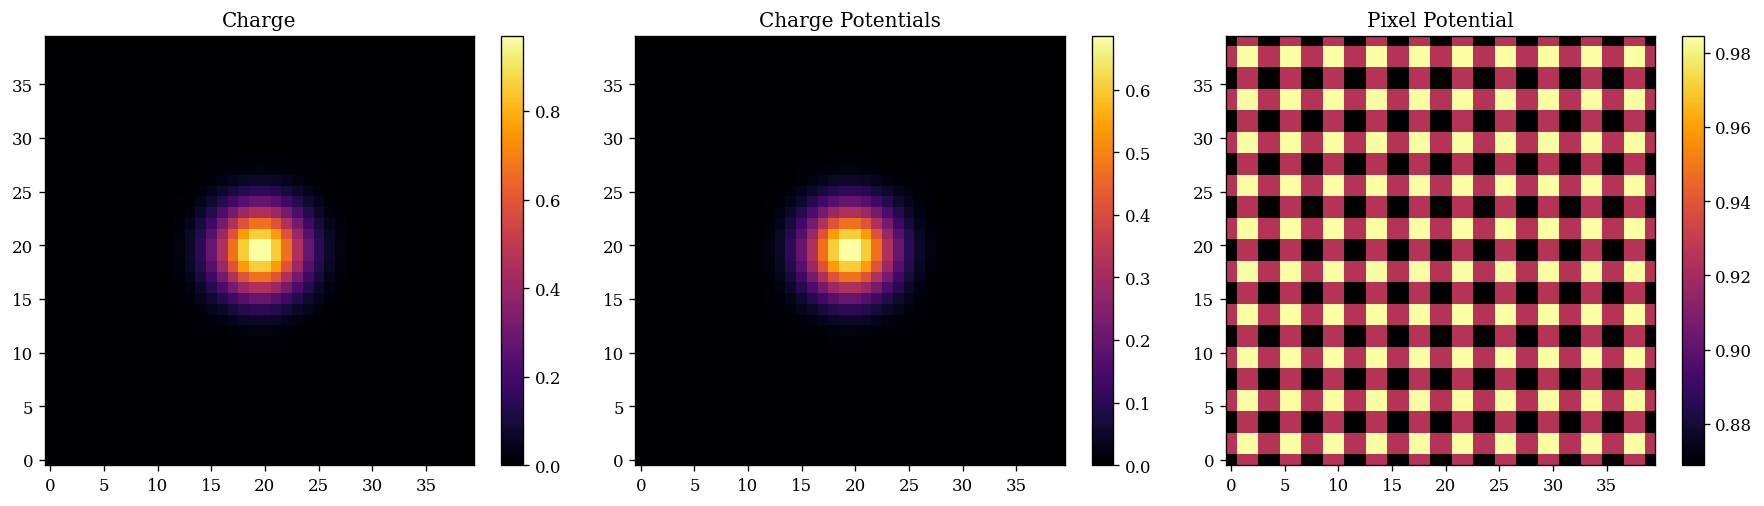

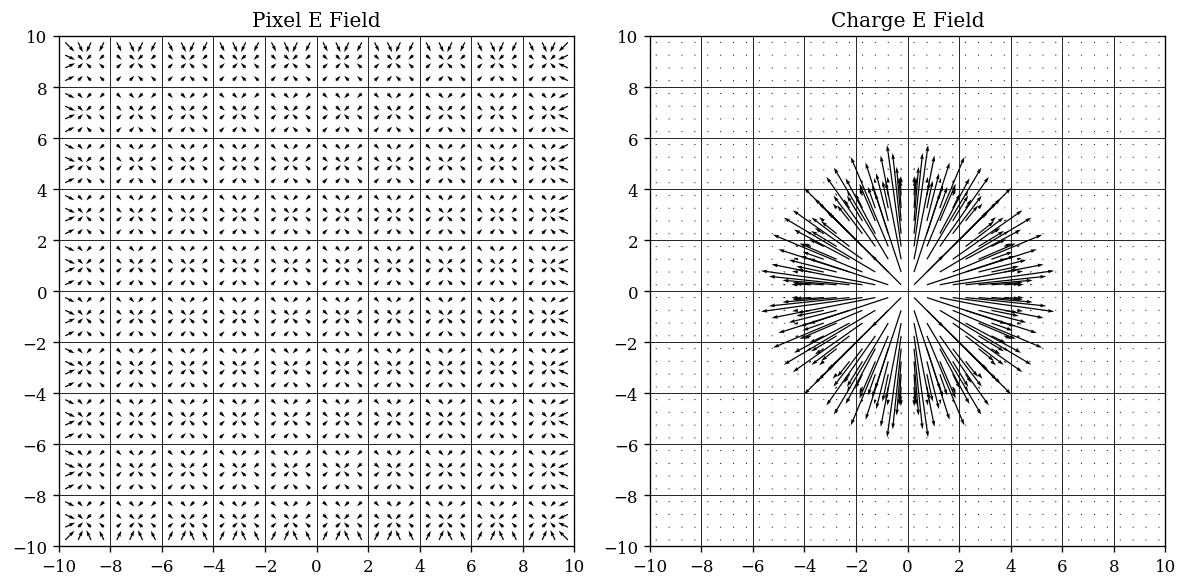

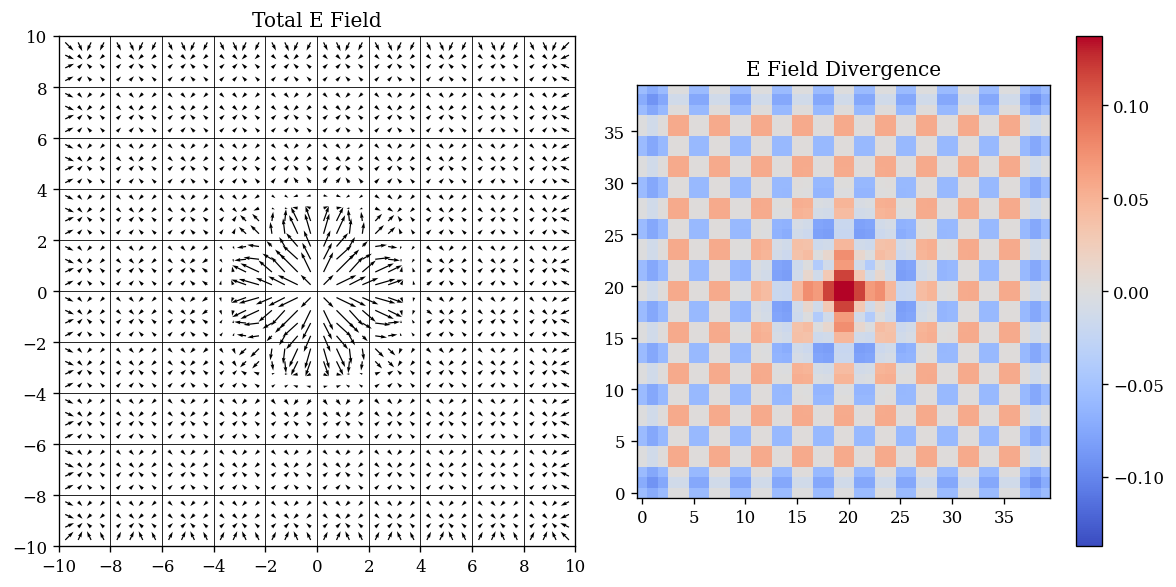

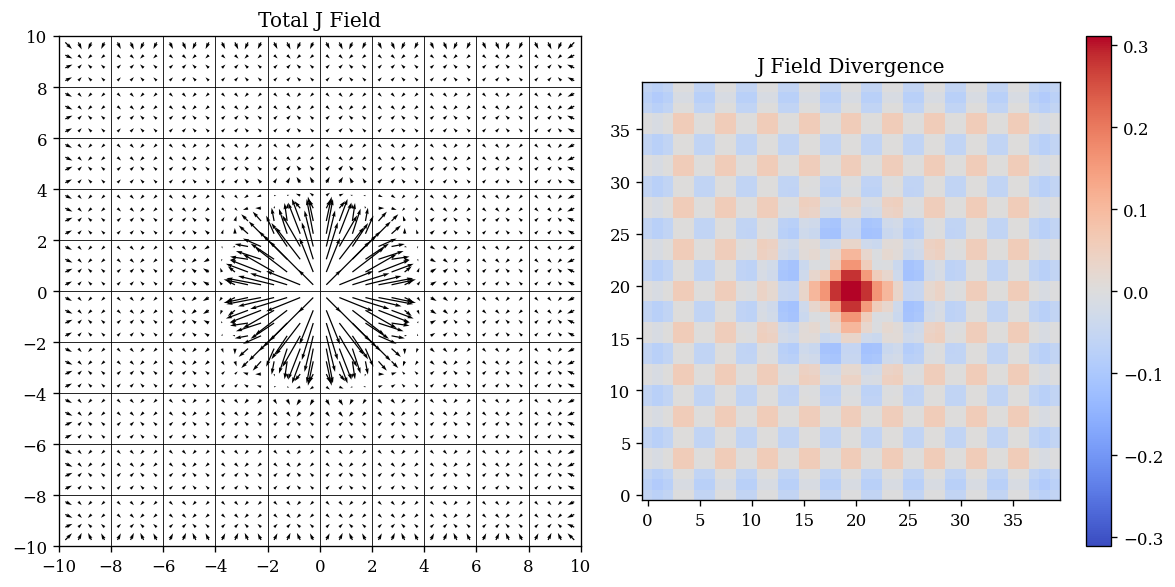

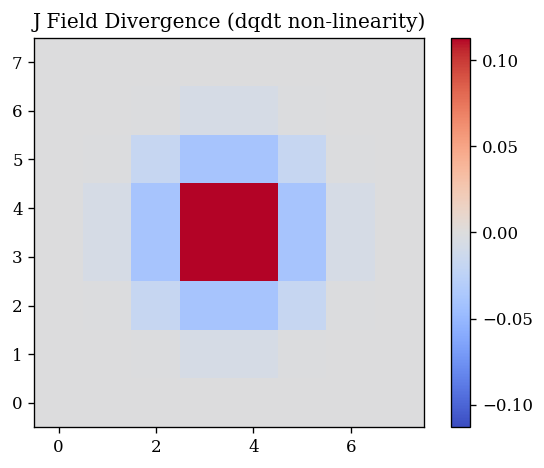

1.685442442658433e-06
0.9058116248285052


In [6]:
import dLux.utils as dlu
import jax.scipy as jsp
from amigo.misc import calc_laplacian

# The constants!
phi = 1  # Overall charge density
zeta = 1e-6  # Electric permittivity
rho = 1  # Pixel potential
sigma = 1 # Conductivity
D = 1  # Diffusion coefficient
epslion = 1e-6 # Green's function singularity

# The pixels
true_npix = 10
oversample = 4
npix = oversample * true_npix

# Get the coordinates of the pixels
xs, ys = dlu.pixel_coords(npix, npix / 2)
dx, dy = np.diff(xs, axis=1).mean(), np.diff(ys, axis=0).mean()
pix_boundaries = np.linspace(xs.min() - dx/2, xs.max() + dx/2, (len(xs)//oversample) + 1)

# Get a gaussian charge distribution
charge = phi * np.exp(-0.5 * (xs**2 + ys**2)) ** 0.5

#
charge_potential = charge_to_potential(charge, zeta)

# Get a gaussian pixel potential
rs = np.hypot(*dlu.pixel_coords(oversample, 1))
pixel_potential = rho * np.exp(-0.5 * rs**2)
pixel_potentials = tile_pixels(pixel_potential, true_npix)

# Get the E-fields
pixel_E_field = potential_to_field(pixel_potentials)
charge_E_field = potential_to_field(-charge_potential)

# Get the total field
E = charge_E_field + pixel_E_field

# Get the divergence of the E field
dEy = np.gradient(E[0], axis=0)
dEx = np.gradient(E[1], axis=1)
E_div = dEx + dEy

# Calculate the diffusion component
charge_gradients = np.array(np.gradient(charge))

# Calculate the divergence of the current field
J = sigma * E - D * charge_gradients
J_div = field_to_divergence(J)

# Get the total J as the sum of current divergence (cut edges too)
real_J_div = dlu.downsample(J_div, oversample)[1:-1, 1:-1]

# Plot the results
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Charge")
plt.imshow(charge)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Charge Potentials")
plt.imshow(charge_potential)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Pixel Potential")
plt.imshow(pixel_potentials)
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Pixel E Field")
plt.quiver(xs, ys, pixel_E_field[1], pixel_E_field[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())

plt.subplot(1, 2, 2)
plt.title("Charge E Field")
plt.quiver(xs, ys, charge_E_field[1], charge_E_field[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Total E Field")
plt.quiver(xs, ys, E[1], E[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())

v = np.nanmax(np.abs(E))
plt.subplot(1, 2, 2)
plt.title("E Field Divergence")
plt.imshow(E_div, 'coolwarm', vmin=-v, vmax=v)
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Total J Field")
plt.quiver(xs, ys, J[1], J[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())

v = np.nanmax(np.abs(J))
plt.subplot(1, 2, 2)
plt.title("J Field Divergence")
plt.imshow(J_div, "coolwarm", vmin=-v, vmax=v)
plt.colorbar()
plt.tight_layout()
plt.show()

v = np.nanmax(np.abs(real_J_div))
plt.figure(figsize=(5, 4))
plt.title("J Field Divergence (dqdt non-linearity)")
plt.imshow(real_J_div, "coolwarm", vmin=-v, vmax=v)
plt.colorbar()
plt.tight_layout()
plt.show()

print(real_J_div.sum())
print(np.abs(real_J_div).sum())

In [7]:
import zodiax as zdx
import dLux.utils as dlu
from amigo.ode_models import ODESolver, ODEFunc
from amigo.ramp_models import Ramp
import jaxlib as jxl
from amigo.misc import calc_laplacian
from amigo.ode_models import Polynomial


class ODERamp(ODESolver):
    psf_downsample: int = eqx.field(static=True)
    ramp_downsample: int = eqx.field(static=True)
    norm: int = eqx.field(static=True)

    def __init__(self, ODE, norm=2**15, psf_downsample=2, ramp_downsample=2):
        super().__init__(ODE)
        self.norm = int(norm)
        self.psf_downsample = psf_downsample
        self.ramp_downsample = ramp_downsample

    def downsample_ramp(self, ramp, n):
        return vmap(lambda x, n: dlu.downsample(x, n, mean=False), (0, None))(ramp, n)

    def solve(self, illuminance, ngroups):
        ts = (np.arange(0, ngroups) + 1) / ngroups
        y0 = np.zeros_like(illuminance)
        args = illuminance
        return self.solve_fn(y0, args, ts)

    def predict_ramp(self, illuminance, ngroups):
        illuminance /= self.norm
        if self.psf_downsample is not None:
            illuminance = dlu.downsample(illuminance, self.psf_downsample, mean=False)
        ramp = self.solve(illuminance, ngroups).ys

        if self.ramp_downsample is not None:
            ramp = self.downsample_ramp(ramp, self.ramp_downsample)
        return self.norm * ramp

    def predict_slopes(self, illuminance, ngroups):
        ramp = self.predict_ramp(illuminance, ngroups)
        return np.diff(ramp, axis=0)

    def apply(self, psf, flux, exposure, oversample):
        ramp = self.predict_ramp(psf.data * flux, exposure.ngroups)
        return Ramp(ramp, psf.pixel_scale)


def tile_pixels(pixel_potential, npix):
    oversample = pixel_potential.shape[0]
    empty = np.ones((npix, npix))
    bc_sens_map = pixel_potential[None, :, None, :] * empty[:, None, :, None]
    return bc_sens_map.reshape((npix * oversample, npix * oversample))


def charge_to_potential(charge, zeta, epsilon=1e-9):
    coords = dlu.pixel_coords(9, 2)
    greens_function = zeta / np.hypot(*(coords + epslion))
    return jsp.signal.convolve(charge, greens_function, mode="same")


def potential_to_field(potential):
    return np.array(np.gradient(potential))


def field_to_divergence(field):
    return np.array(np.gradient(field[0], axis=0)) + np.array(
        np.gradient(field[1], axis=1)
    )


class CurrentODE(zdx.Base, ODEFunc):
    # TODO: Potential improvement - predict the diffusion, electric and pixel
    # coefficients using a conv net
    pixel_kernel: np.ndarray
    pixel_potential: np.ndarray
    electric_permittivity: np.ndarray
    diffusion_coefficient: np.ndarray
    gain: Polynomial

    def __init__(
        self,
        start=1,
        order=3,
        pixel_potential=0.,
        electric_permittivity=0.,
        diffusion_coefficient=0.,
        pixel_kernel=None,
    ):
        self.gain = Polynomial(start, order)
        self.pixel_potential = np.array(pixel_potential, float)
        self.electric_permittivity = np.array(electric_permittivity, float)
        self.diffusion_coefficient = np.array(diffusion_coefficient, float)

        if pixel_kernel is None:
            rs = np.hypot(*dlu.pixel_coords(4, 1))
            pixel_kernel = np.exp(-0.5 * rs**2)
        self.pixel_kernel = np.array(pixel_kernel, float)

    def __getattr__(self, key):
        if hasattr(self.gain, key):
            return getattr(self.gain, key)
        raise AttributeError(f"Attribute {key} not found")

    def calculate_E_field(self, charge):
        # Get the scalar potentials
        charge_potential = self.electric_permittivity * charge_to_potential(charge, 1.0)
        pixel_potential = self.pixel_potential * tile_pixels(self.pixel_kernel, 80)

        # Get the E-fields
        pixel_E_field = potential_to_field(pixel_potential)
        charge_E_field = potential_to_field(-charge_potential)
        return charge_E_field + pixel_E_field

    def calculate_diffusion_field(self, charge):
        charge_gradients = np.array(np.gradient(charge))
        return self.diffusion_coefficient * charge_gradients

    def calculate_current_density(self, charge):
        potential_term = self.calculate_E_field(charge)
        diffusion_term = self.calculate_diffusion_field(charge)
        return potential_term - diffusion_term

    def derivative(self, t, charge, illuminance):
        return (
            illuminance
            + illuminance * self.gain.evaluate_arr(charge)
            + field_to_divergence(self.calculate_current_density(charge))
        )

In [8]:
exp = exposures[0]
psf = exp.fit.model_psf(model, exp)
psf, flux, oversample = exp.fit.model_ramp(psf, model, exp, to_BFE=True)
illuminance = psf * flux / 2 ** 15

# Check the ODE init
ODE = CurrentODE(
    pixel_potential=1e-6,
    electric_permittivity=1e-11,
    diffusion_coefficient=0.0,
)
J_00 = ODE.calculate_current_density(0. * illuminance)
J_01 = ODE.calculate_current_density(0.1 * illuminance)
J_10 = ODE.calculate_current_density(illuminance)

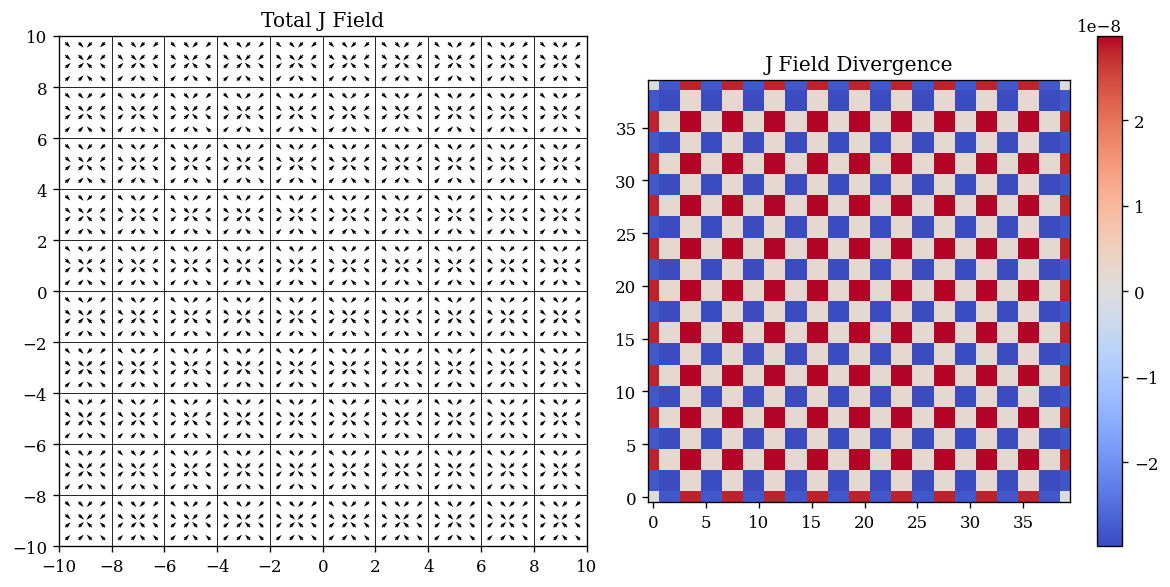

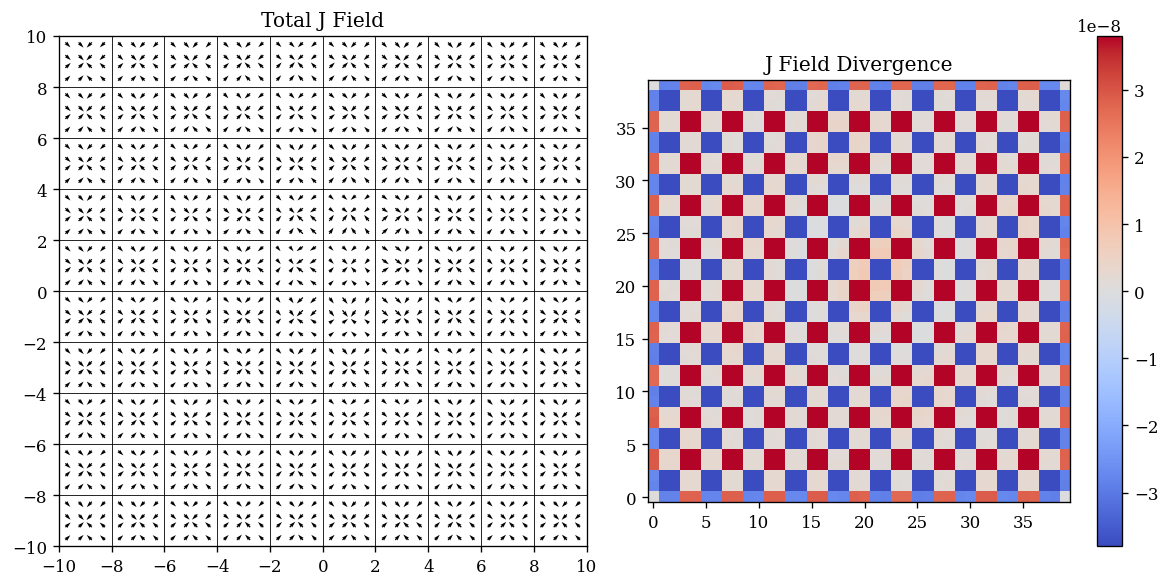

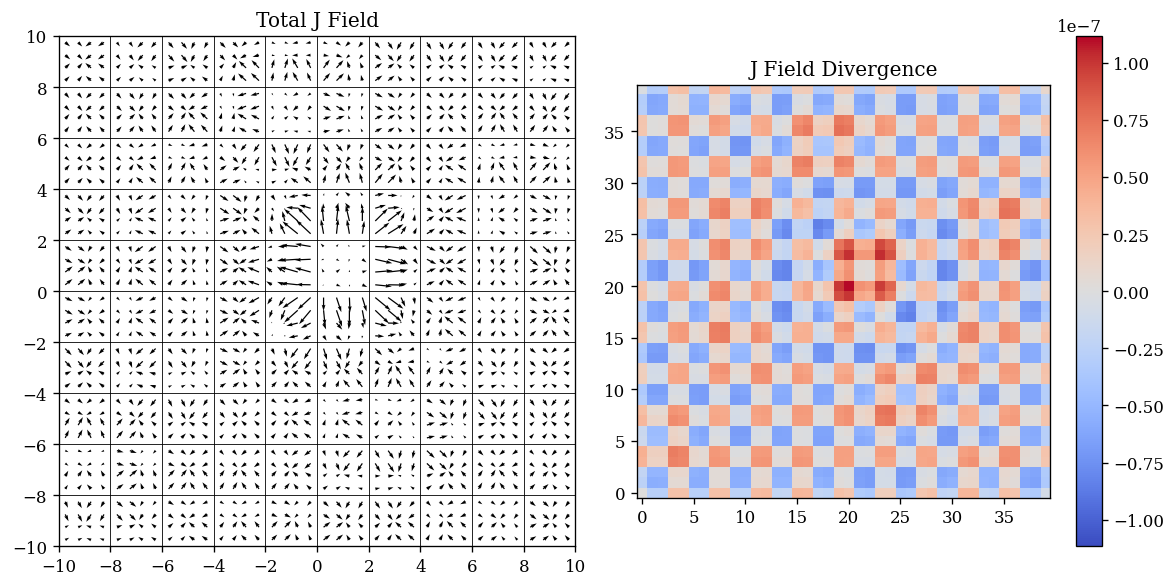

In [9]:
# Get the coordinates of the pixels
small_J = J_00[:, 140:180, 160:200]
oversample = 4
xs, ys = dlu.pixel_coords(40, 40 / 2)
dx, dy = np.diff(xs, axis=1).mean(), np.diff(ys, axis=0).mean()
pix_boundaries = np.linspace(
    xs.min() - dx / 2, xs.max() + dx / 2, (len(xs) // oversample) + 1
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Total J Field")
plt.quiver(xs, ys, small_J[1], small_J[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())

v = np.nanmax(np.abs(small_J))
plt.subplot(1, 2, 2)
plt.title("J Field Divergence")
plt.imshow(field_to_divergence(small_J), "coolwarm", vmin=-v, vmax=v)
plt.colorbar()
plt.tight_layout()
plt.show()

# Get the coordinates of the pixels
small_J = J_01[:, 140:180, 160:200]
oversample = 4
xs, ys = dlu.pixel_coords(40, 40 / 2)
dx, dy = np.diff(xs, axis=1).mean(), np.diff(ys, axis=0).mean()
pix_boundaries = np.linspace(
    xs.min() - dx / 2, xs.max() + dx / 2, (len(xs) // oversample) + 1
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Total J Field")
plt.quiver(xs, ys, small_J[1], small_J[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())

v = np.nanmax(np.abs(small_J))
plt.subplot(1, 2, 2)
plt.title("J Field Divergence")
plt.imshow(field_to_divergence(small_J), "coolwarm", vmin=-v, vmax=v)
plt.colorbar()
plt.tight_layout()
plt.show()

# Get the coordinates of the pixels
small_J = J_10[:, 140:180, 160:200]
oversample = 4
xs, ys = dlu.pixel_coords(40, 40 / 2)
dx, dy = np.diff(xs, axis=1).mean(), np.diff(ys, axis=0).mean()
pix_boundaries = np.linspace(
    xs.min() - dx / 2, xs.max() + dx / 2, (len(xs) // oversample) + 1
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Total J Field")
plt.quiver(xs, ys, small_J[1], small_J[0])
plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)
plt.xticks(pix_boundaries)
plt.yticks(pix_boundaries)
plt.xlim(pix_boundaries.min(), pix_boundaries.max())
plt.ylim(pix_boundaries.min(), pix_boundaries.max())

v = np.nanmax(np.abs(small_J))
plt.subplot(1, 2, 2)
plt.title("J Field Divergence")
plt.imshow(field_to_divergence(small_J), "coolwarm", vmin=-v, vmax=v)
plt.colorbar()
plt.tight_layout()
plt.show()

# Get the coordinates of the pixels
small_J = J_10[:, 140:180, 160:200]
oversample = 4
xs, ys = dlu.pixel_coords(40, 40 / 2)
dx, dy = np.diff(xs, axis=1).mean(), np.diff(ys, axis=0).mean()
pix_boundaries = np.linspace(
    xs.min() - dx / 2, xs.max() + dx / 2, (len(xs) // oversample) + 1
)

In [10]:
# Make the model
ode_model = ODERamp(ODE, psf_downsample=1, ramp_downsample=4)
model = model.set("ramp", ode_model)
ode_model

ODERamp(
  ODE=CurrentODE(
    pixel_kernel=f64[4,4],
    pixel_potential=f64[],
    electric_permittivity=f64[],
    diffusion_coefficient=f64[],
    gain=Polynomial(powers=(1, 2, 3), coeffs=f64[3])
  ),
  psf_downsample=1,
  ramp_downsample=4,
  norm=32768
)

In [12]:
from amigo.fisher import calc_fishers

fishers = calc_fishers(
    model.set("ramp", None),
    exposures,
    ["fluxes"],
    cache="../files/fishers_old",
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
from amigo.fitting import sgd, adam, optimise

# Get number of batches
batch_size = 1
if batch_size > len(exposures):
    batch_size = len(exposures)
nbatch = len(exposures) // batch_size
if len(exposures) % batch_size != 0:
    nbatch += 1

# Define the optimisers
optimisers = {
    "ramp.electric_permittivity": sgd(1e-15, 0),
    "ramp.coeffs": sgd(2e-2, 3),
    "fluxes": sgd(5e-1, 6),
    "ramp.diffusion_coefficient": sgd(1e-4, 9),
    "ramp.pixel_potential": sgd(2e-7, 9),
    "ramp.pixel_kernel": sgd(1e-6, 9),
}

# Optimise!
epochs = 50
final_model, losses, final_state, history = optimise(
    model,
    exposures,
    optimisers,
    epochs=epochs,
    batch_size=batch_size,
    fishers=fishers,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:00:24
Initial Loss: 97.38
Est time per epoch:  0:00:07
Est run time:  0:06:34
Full Time: 0:06:23
Final Loss: 36.93


36.93490045127587


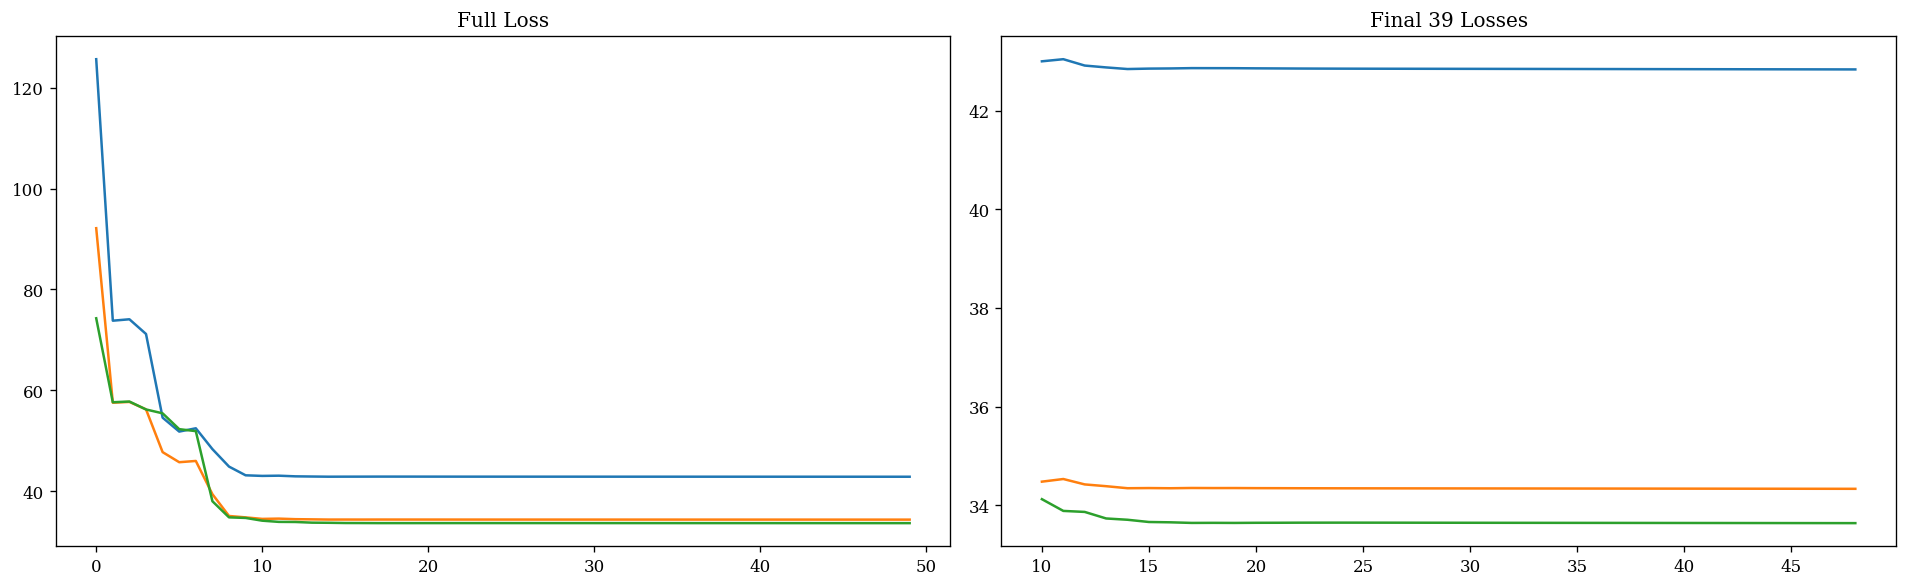

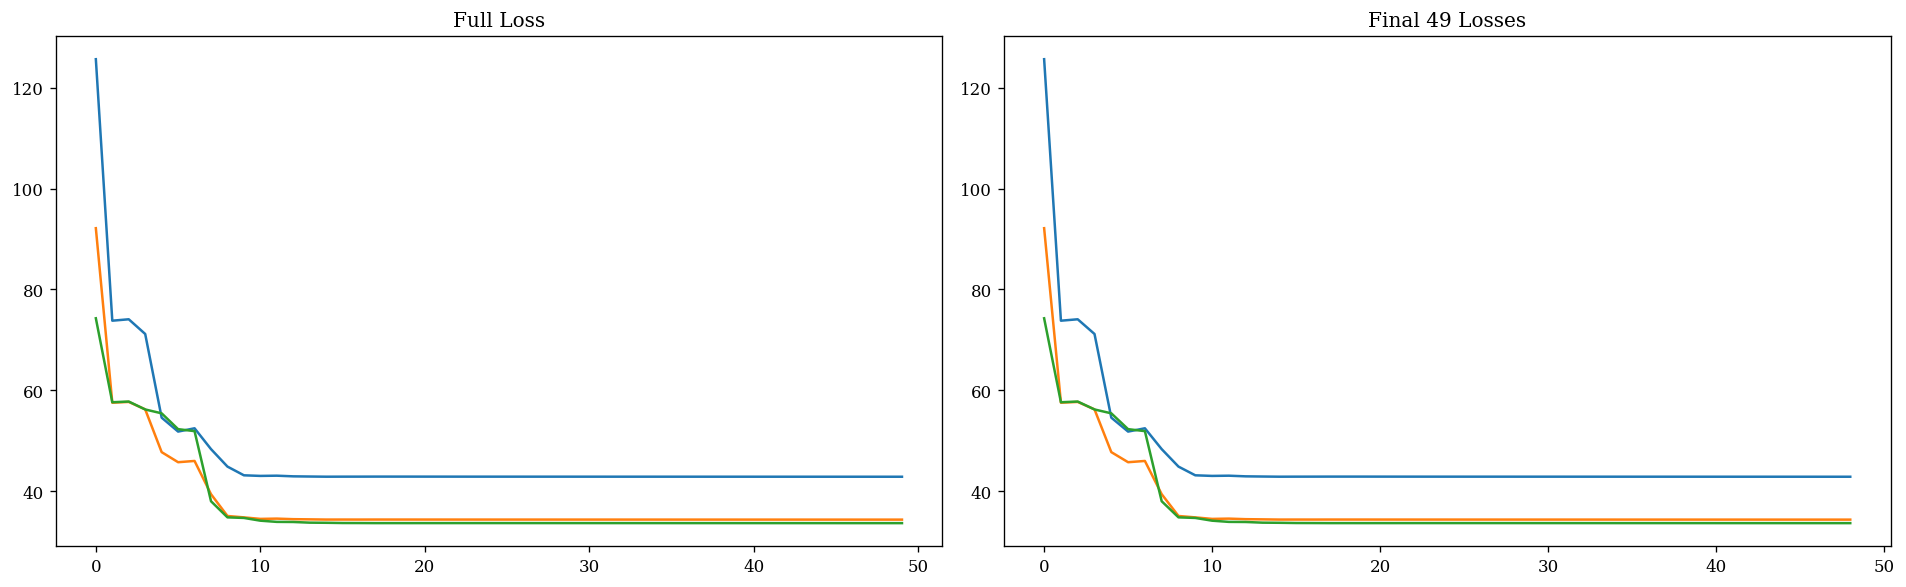

No formatting function for ramp.coeffs


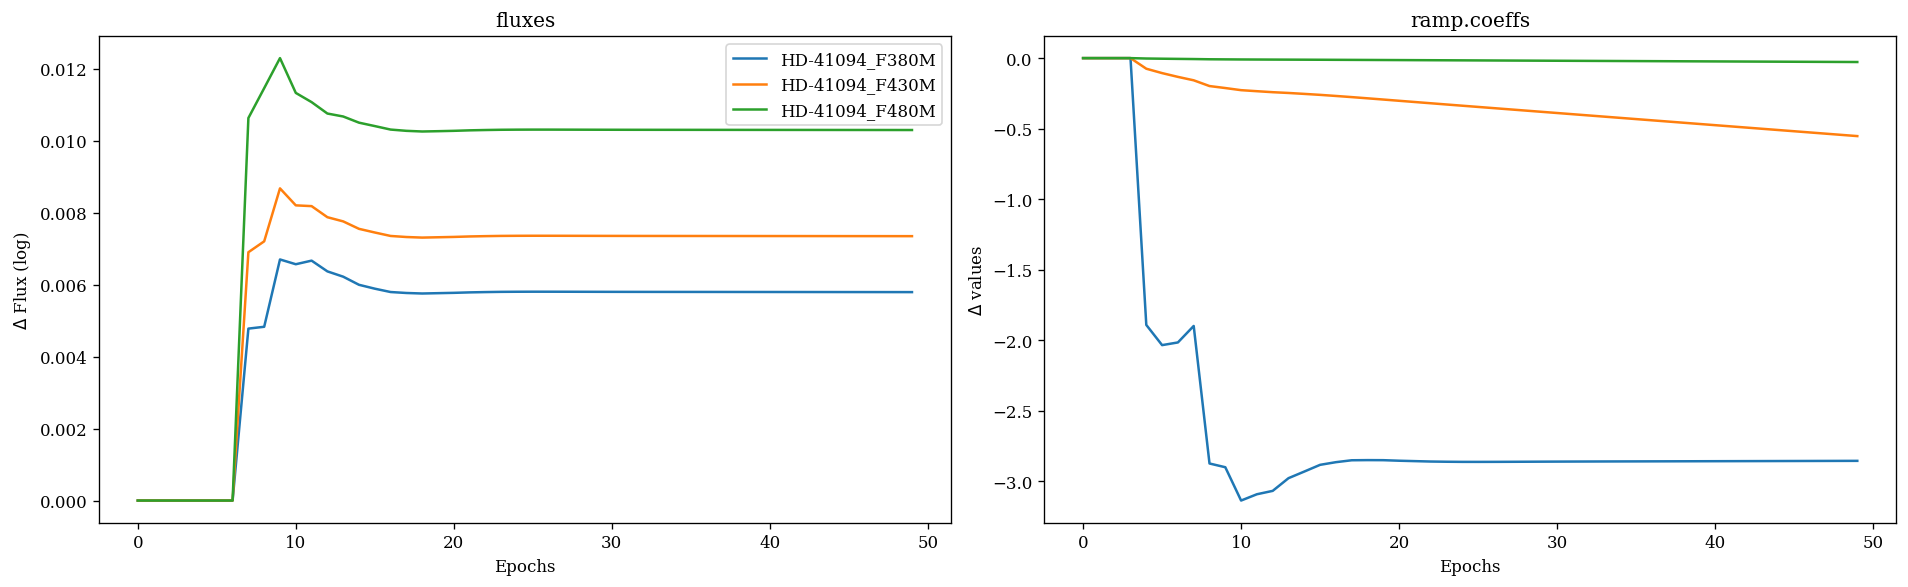

No formatting function for ramp.diffusion_coefficient
No formatting function for ramp.electric_permittivity


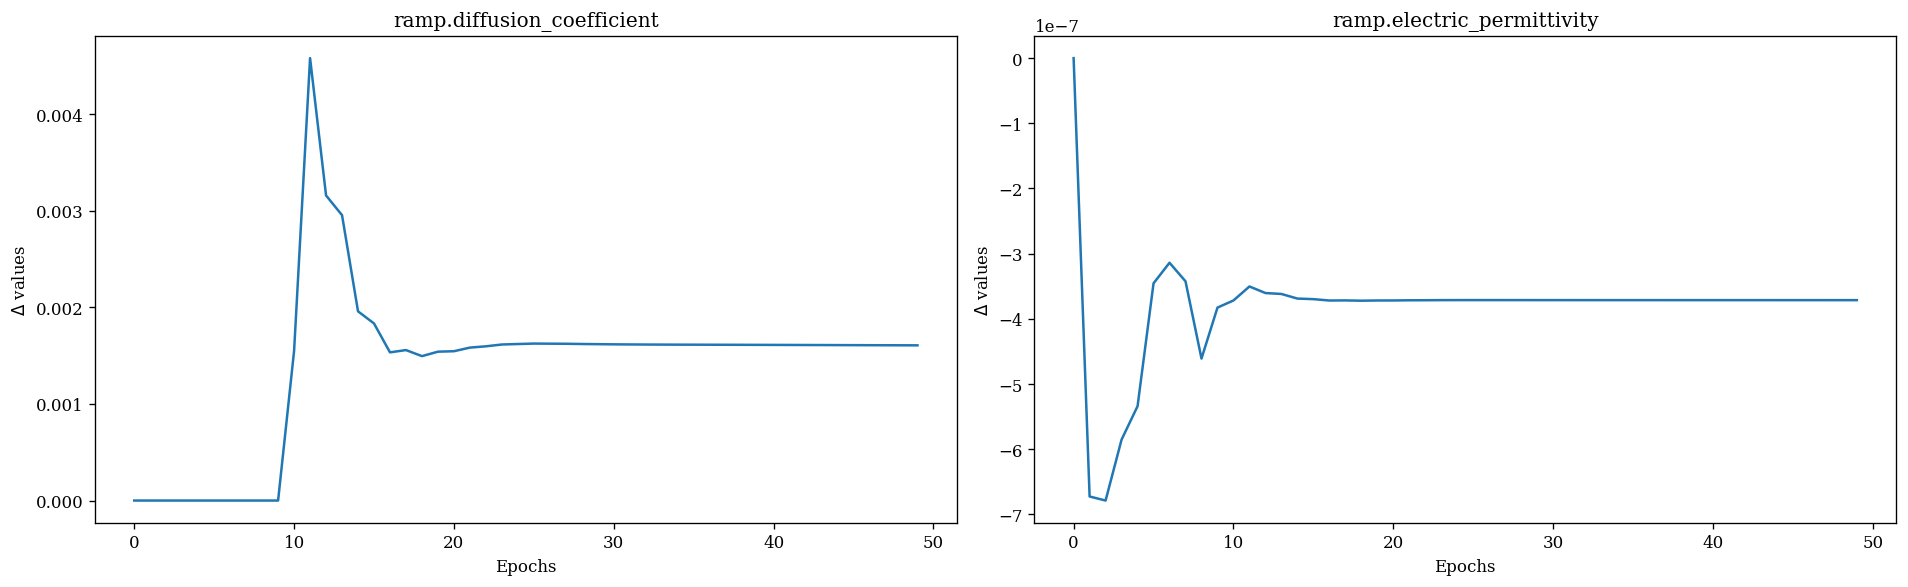

No formatting function for ramp.pixel_kernel
No formatting function for ramp.pixel_potential


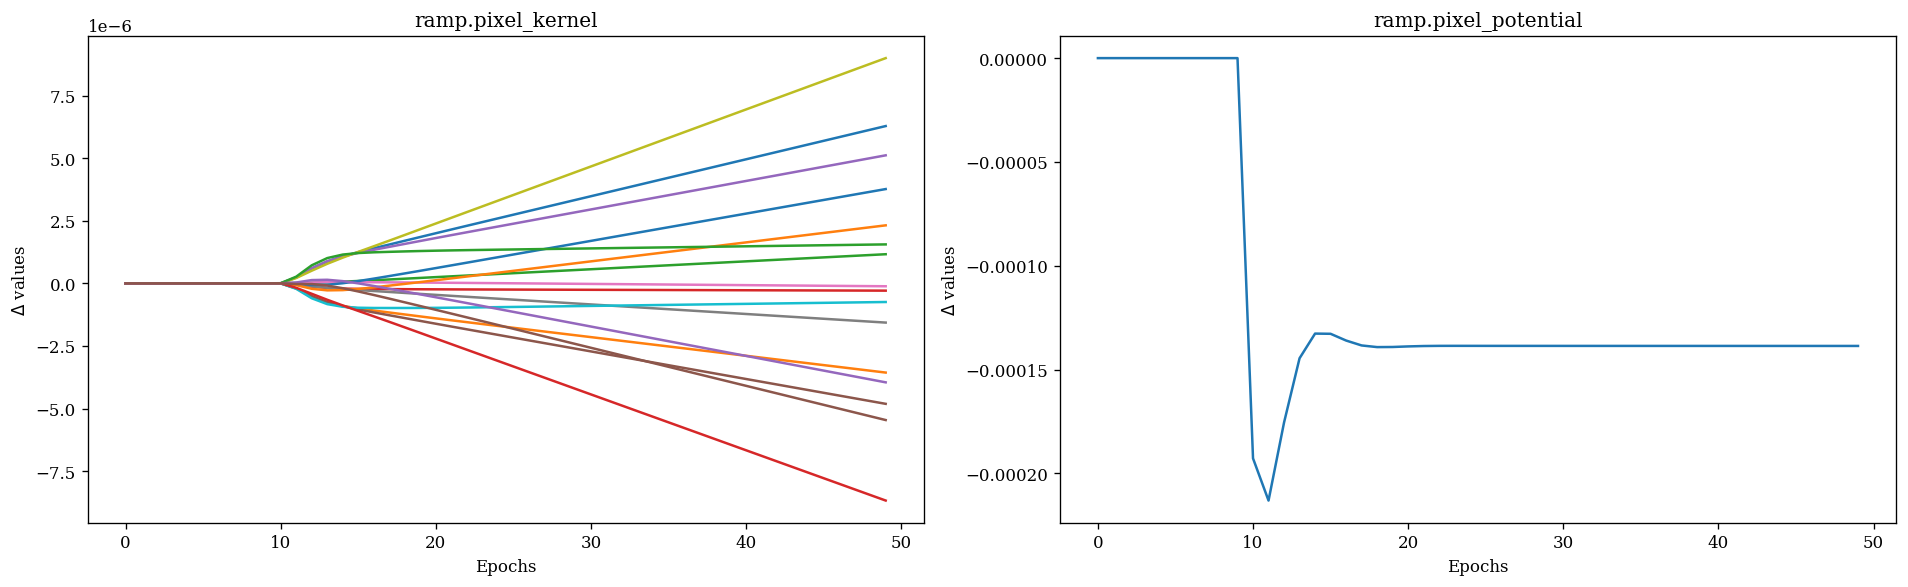

In [14]:
from amigo.plotting import plot, plot_losses

print(losses[-1].mean() / batch_size)

plot_losses(np.array(losses) / batch_size, start=10, stop=-1)
plot_losses(np.array(losses) / batch_size, start=100, stop=-1)

plot(history)

F430M


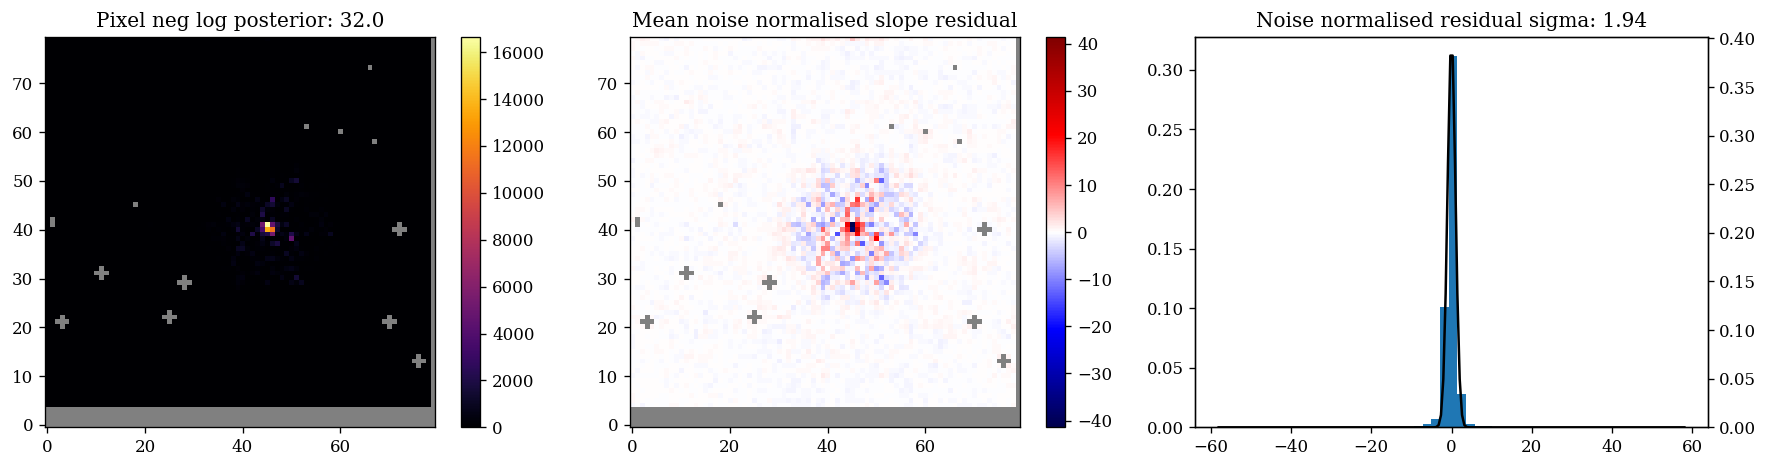

F480M


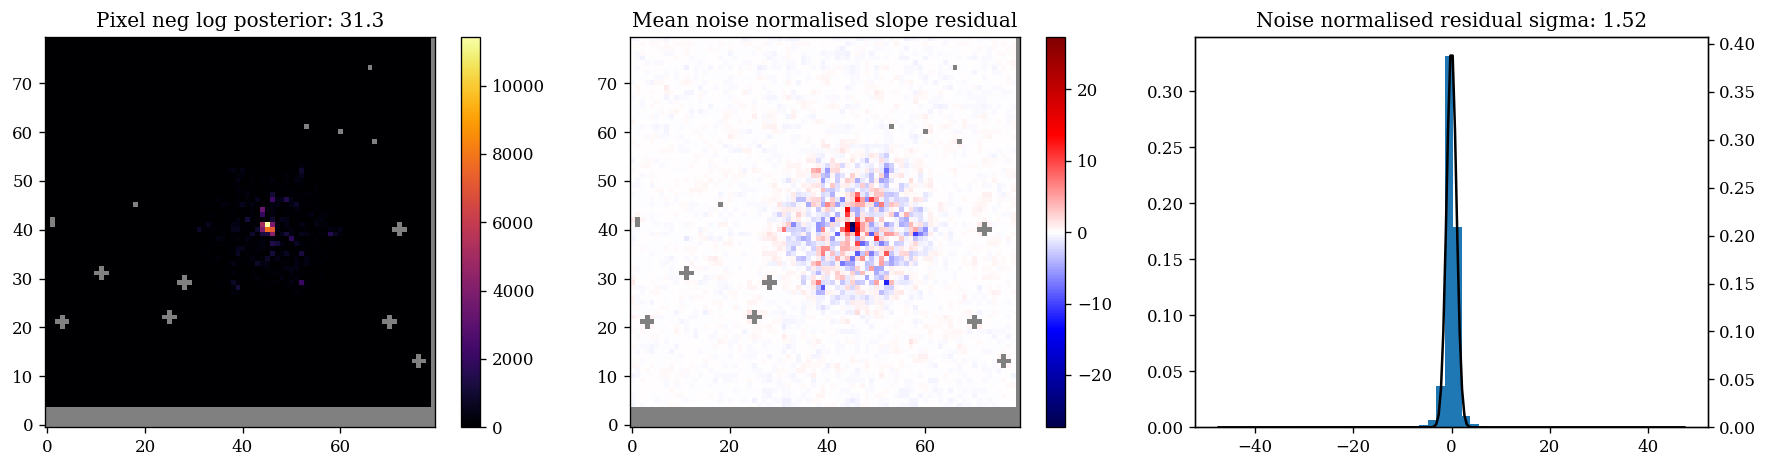

F380M


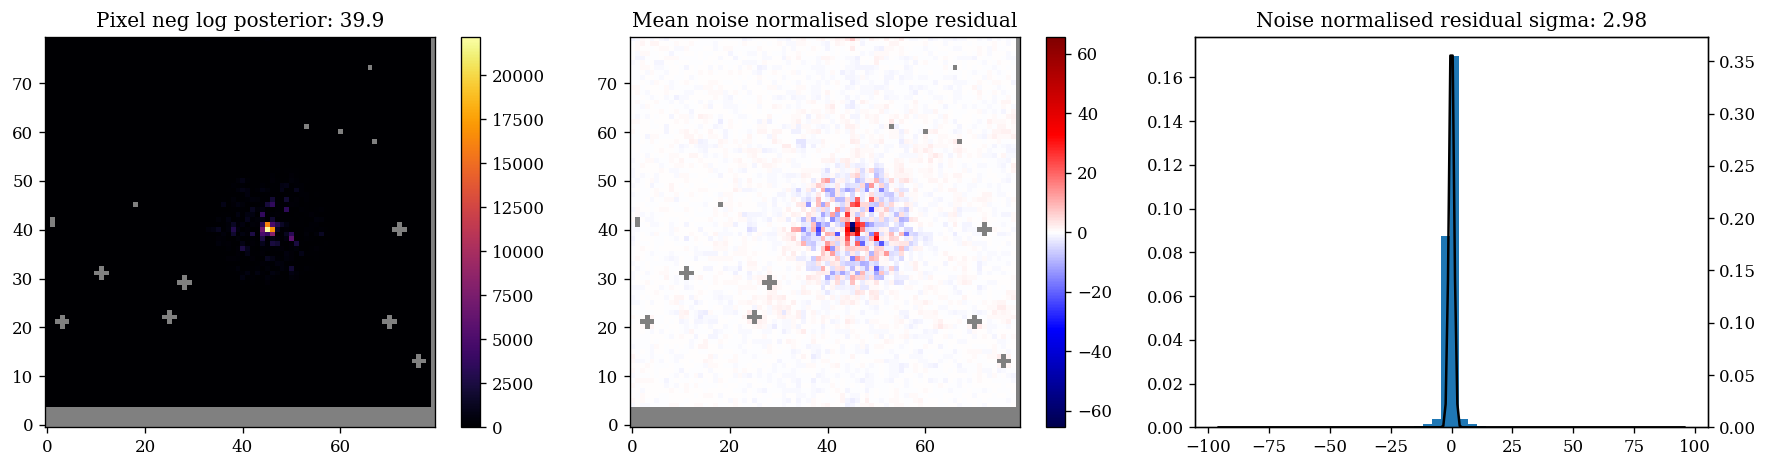

In [15]:
from amigo.plotting import summarise_fit

for exp in exposures:
    print(exp.filter)
    summarise_fit(exp, final_model)